<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

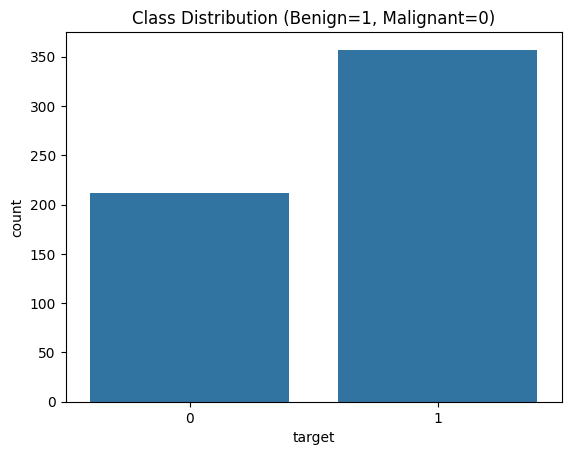

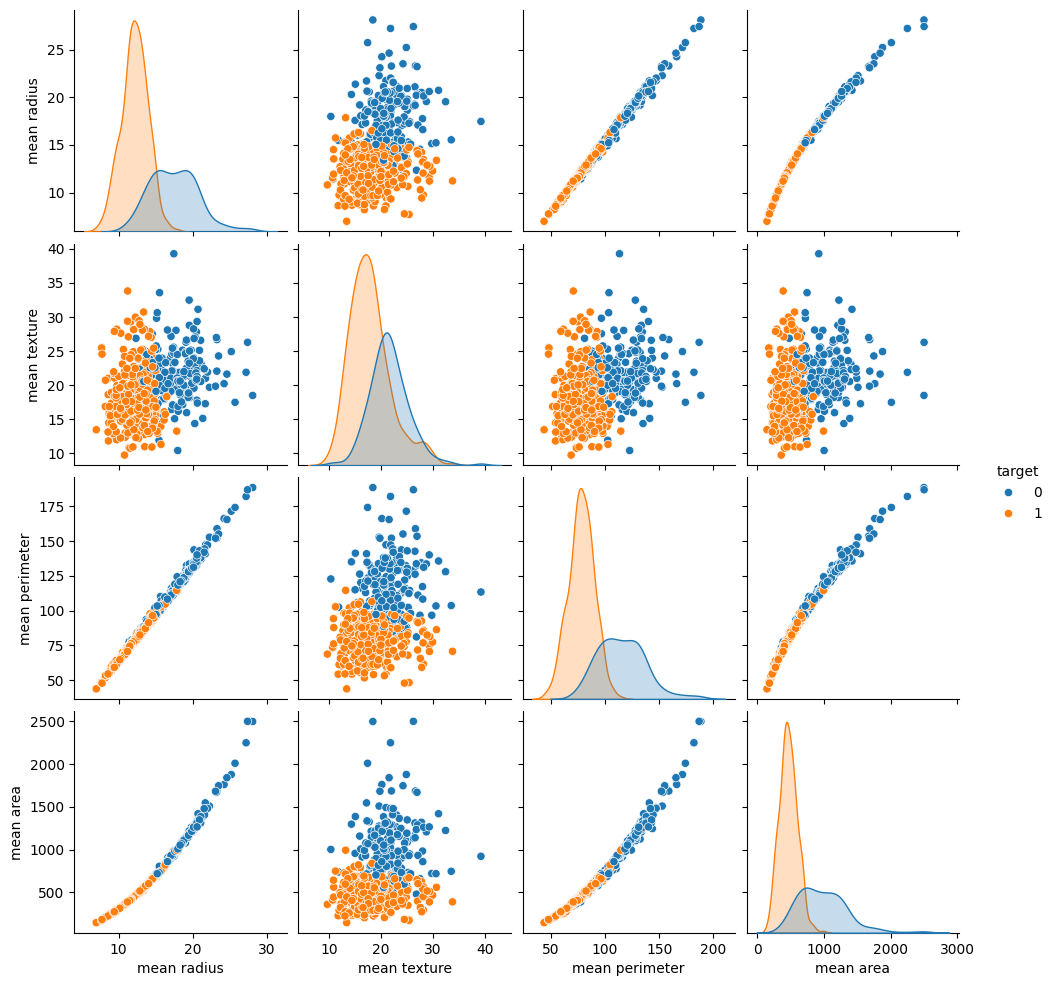

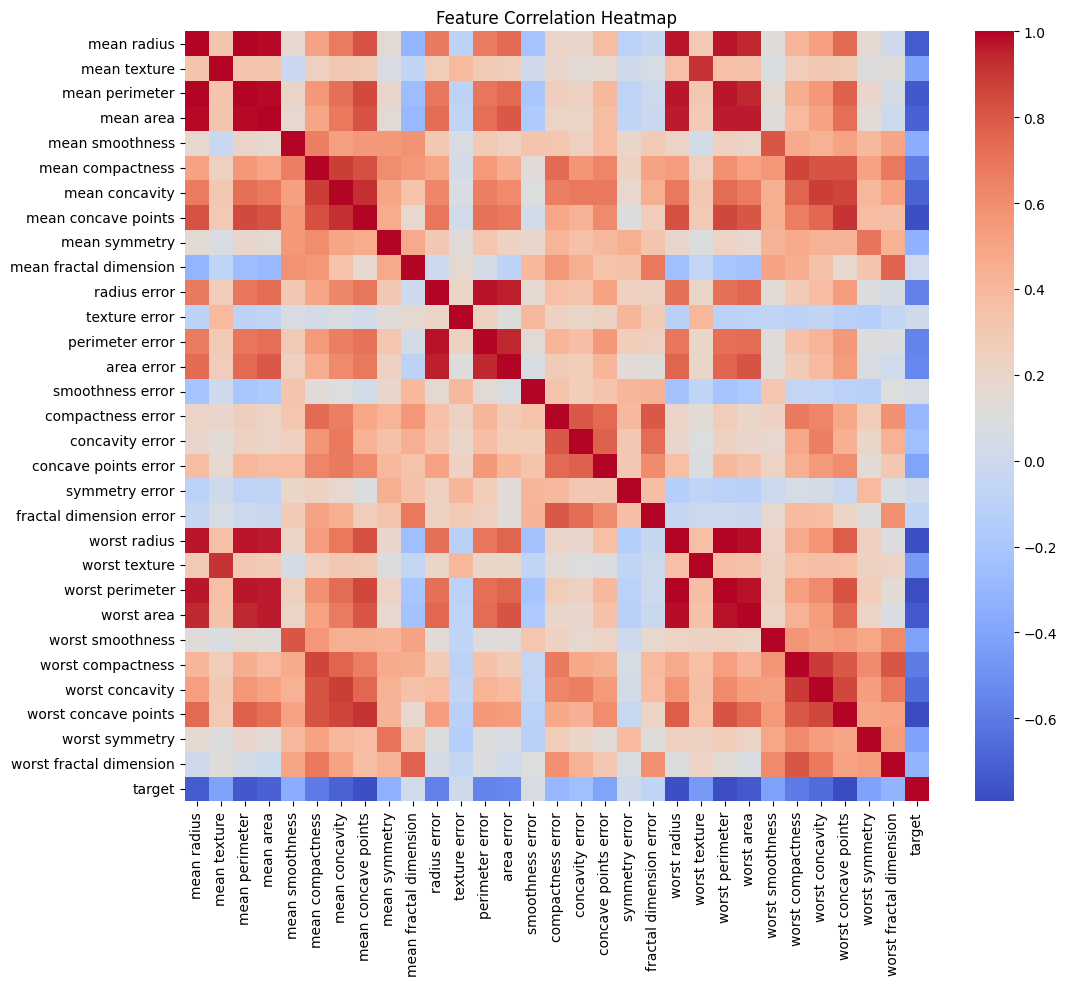


Training and Evaluating: Logistic Regression
Accuracy: 0.9736842105263158
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Confusion Matrix:
 [[41  1]
 [ 2 70]]
ROC-AUC Score: 0.9953703703703703

Training and Evaluating: Random Forest
Accuracy: 0.9210526315789473
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        42
           1       0.94      0.93      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114

Confusion Matrix:
 [[38  4]
 [ 5 67]]
ROC-AUC Score: 0.9849537037037037

Training 

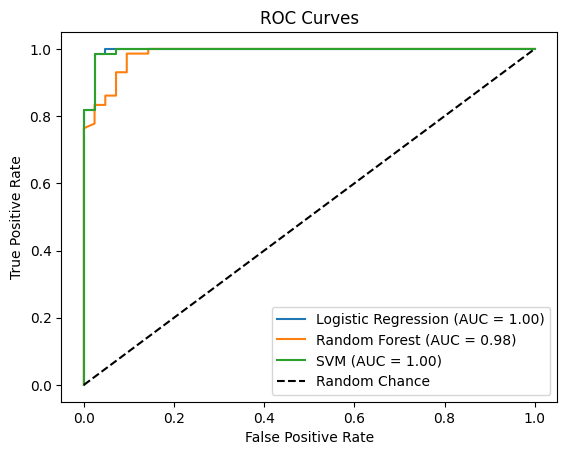


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Final Random Forest Accuracy: 0.9122807017543859


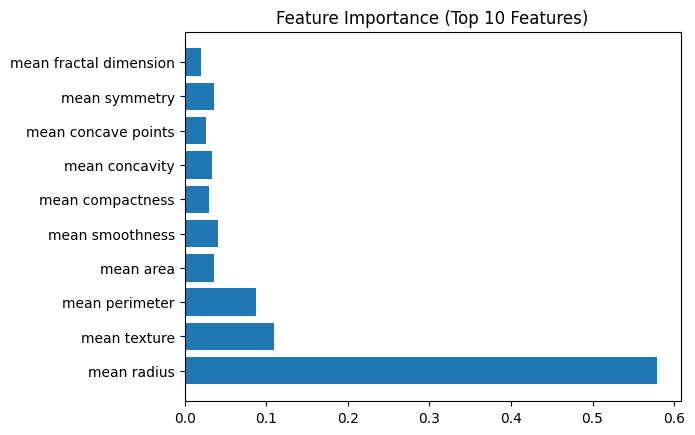

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Load the Breast Cancer Wisconsin dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)#converts the csv file into dataframe 
df['target'] = data.target #extra comlumn is added called target to define wheather malignant(0) or bening(1)

# Exploratory Data Analysis
print("Dataset Info:\n", df.info())#provides summary of the data set
print("\nClass Distribution:\n", df['target'].value_counts()) #counts the value of the target column i.e (how many bening how many malignant)
sns.countplot(x='target', data=df) #plots a bar graph
plt.title("Class Distribution (Benign=1, Malignant=0)")
plt.show()

# Pairplot for first few features
sns.pairplot(df, vars=data.feature_names[:4], hue='target', diag_kind='kde')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()#correlates between 2 matrix  
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Split data into features and target
X = df.iloc[:, :-1] # These are the input variables used by the model to make predictions.from 1st coloumn to 2nd last
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #f you set random_state=42, it ensures the split is the same every time


# Feature scaling
scaler = StandardScaler()#Standardization: Scales features to have zero mean and unit variance. Improves performance for many algorithms.
Purpose: Ensures all features are on the same scale, preventing dominance of larger-valued features.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dimensionality reduction (optional)
pca = PCA(n_components=10)# PCA: Reduces features to 10 components while retaining most variance.
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining and Evaluating: {name}")
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_proba = model.predict_proba(X_test_pca)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    if y_proba is not None:
        roc_auc = roc_auc_score(y_test, y_proba)
        print("ROC-AUC Score:", roc_auc)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    results[name] = accuracy

# Plot ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_pca, y_train)

# Best parameters
print("\nBest Parameters for Random Forest:", grid_search.best_params_)

# Final Random Forest model
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_pca)
print("\nFinal Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

# Feature importance from Random Forest
importances = best_rf.feature_importances_
plt.barh(data.feature_names[:10], importances)
plt.title("Feature Importance (Top 10 Features)")
plt.show()


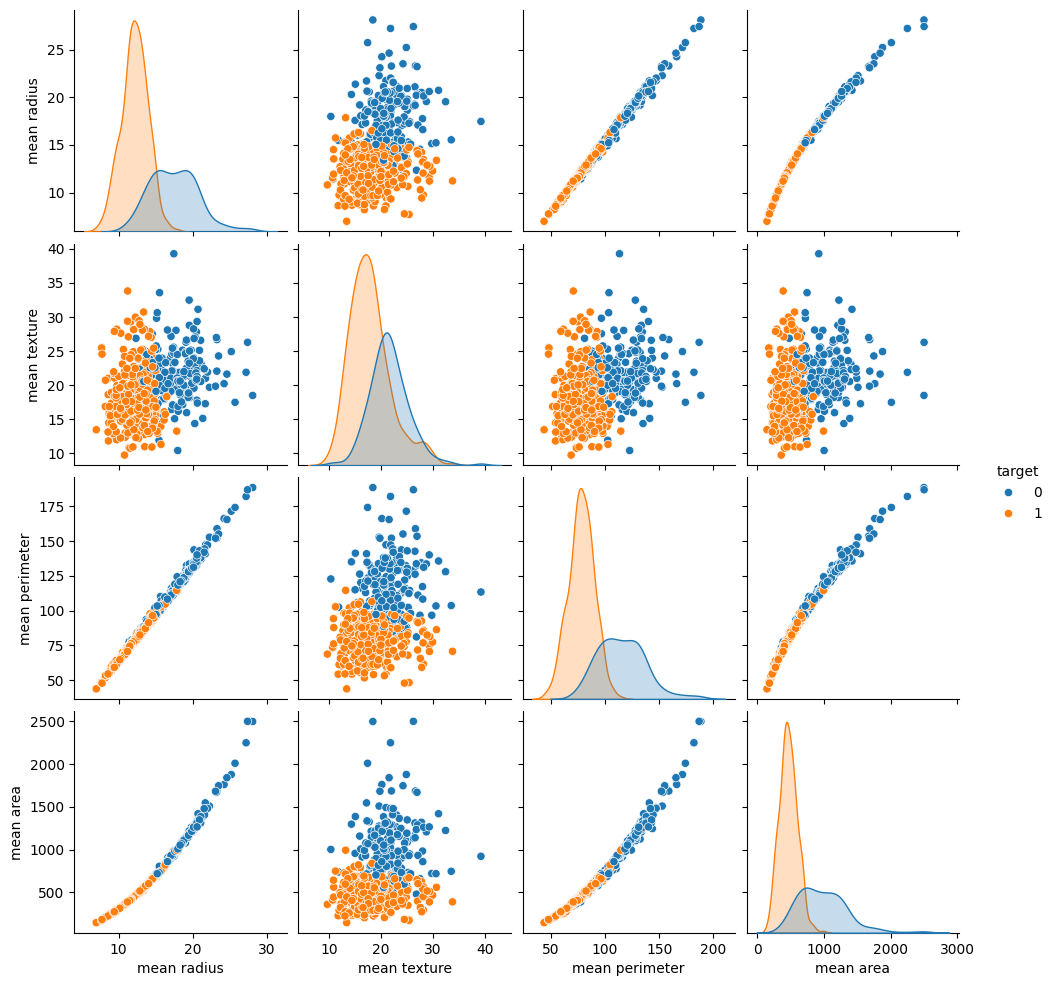

In [4]:
sns.pairplot(df, vars=data.feature_names[:4], hue='target', diag_kind='kde')#kernel density estimation
plt.show()